In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
def calculate_metrics_with_oe(ref, calculated, tolerance=10):
    """
    Calculate Acc1, Acc2, Metric3, OE1, and OE2.
    Args:
        ref (np.ndarray): Reference BPMs.
        calculated (np.ndarray): Estimated BPMs.
        tolerance (float): Precision window (default 4%).
    Returns:
        dict: Dictionary with Acc1, Acc2, Metric3, OE1, and OE2 values.
    """
    # ref_tolerance = ref * tolerance
    ref_tolerance = tolerance
    # Acc1: Within 4% of reference BPM
    acc1_count = np.sum(np.abs(calculated - ref) <= ref_tolerance)
    
    # Acc2: Within 4% of reference BPM, double, or half
    acc2_count = np.sum(
        (np.abs(calculated - ref) <= ref_tolerance) |
        (np.abs(calculated - 2 * ref) <= ref_tolerance) |
        (np.abs(calculated - ref / 2) <= ref_tolerance)
    )
    
    # Metric3: Within 4% of 1x, 2x, 1/2x, 3x, 1/3x, 4x, 1/4x, 6x
    scales = [1, 2, 0.5, 3, 1/3, 4, 1/4, 6]
    metric3_count = 0
    for scale in scales:
        metric3_count += np.sum(np.abs(calculated - ref * scale) <= ref_tolerance)
    
    # OE1: Overestimated BPM outside hierarchical relationships
    oe1_count = np.sum(
        (calculated > ref) &  # Overestimation
        ~np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Not within any scale
    )
    
    # OE2: Overestimated BPM within hierarchical relationships
    oe2_count = np.sum(
        (calculated > ref) &  # Overestimation
        np.any([np.abs(calculated - ref * scale) <= ref_tolerance for scale in scales], axis=0)  # Within any scale
    )
    
    total = len(ref)
    
    metrics = {
        "Acc1": (acc1_count / total) * 100,
        "Acc2": (acc2_count / total) * 100,
        "Metric3": (metric3_count / total) * 100,
        "OE1": (oe1_count / total) * 100,
        "OE2": (oe2_count / total) * 100,
    }
    return metrics


### oe1 oe2 acc1 acc2 m3

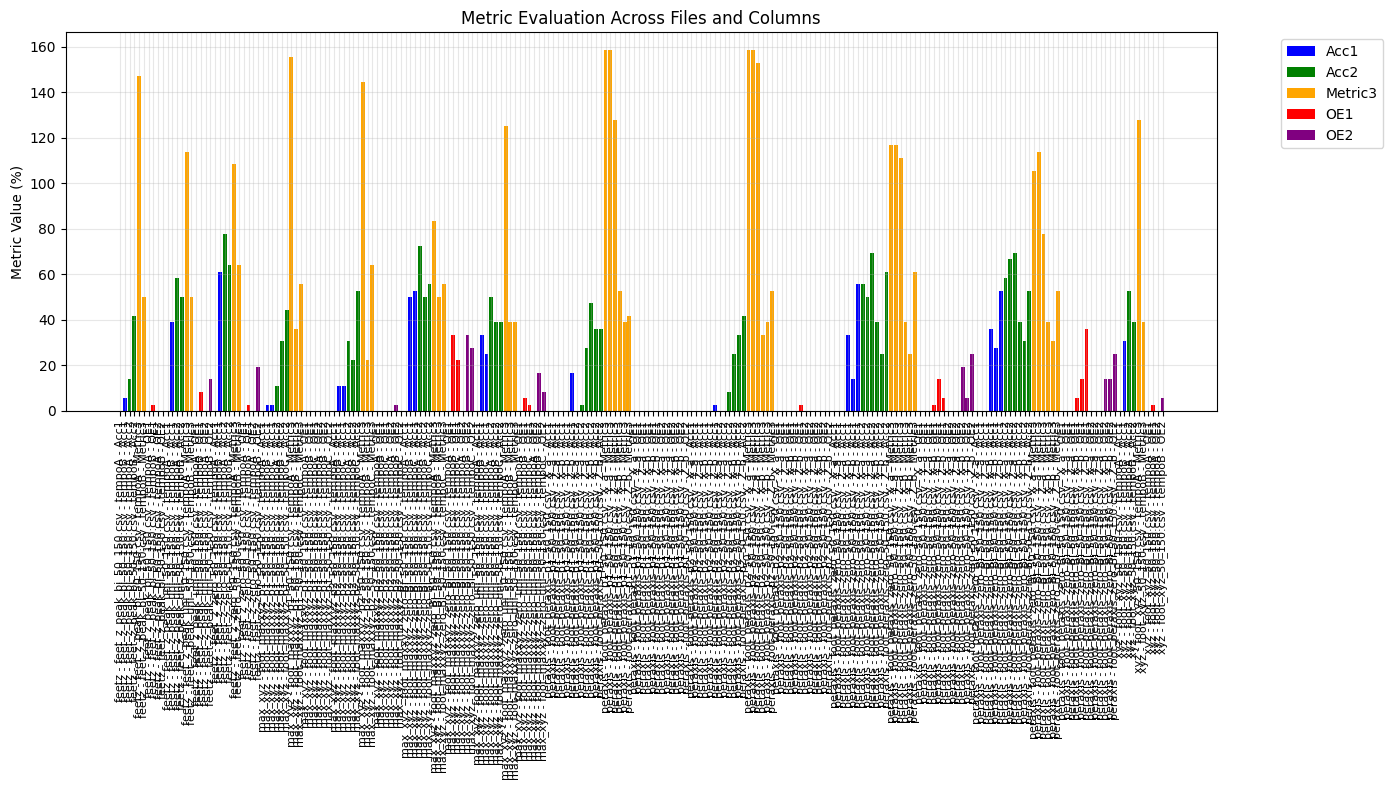

In [11]:
# Folder structure and file mapping
folders = {
    "feetz": ["feet_z_peak_bi_50_150.csv", "feet_z_peak_uni_50_150.csv", "feet_z_zero_50_150.csv"],
    "max_xyz": ["foot_maxxyz_p1_50_150.csv", "foot_maxxyz_p2_50_150.csv", "foot_maxxyz_zero_Bi_50_150.csv", "foot_maxxyz_zero_uni_50_150.csv"],
    "peraxis": ["foot_peraxis_p1_50_150.csv", "foot_peraxis_p2_50_150.csv", "foot_peraxis_zero_50_150.csv", "foot_peraxis_zero_Bi_50_150.csv"],
    "xyz": ["foot_xyz_50_150.csv"]
}

columns_to_process = {
    "feetz": ["tempoA", "tempoB"],
    "max_xyz": ["tempoA", "tempoB", "tempoC"],
    "peraxis": ["X_a", "Y_a", "Z_a", "X_b", "Y_b", "Z_b"],
    "xyz": ["tempoA", "tempoB"]
}

# Base folder path (adjust as needed)
base_folder = "./"

# Initialize results dictionary
results = {}

# Define consistent colors for metrics
metric_colors = {
    "Acc1": "blue",
    "Acc2": "green",
    "Metric3": "orange",
    "OE1": "red",
    "OE2": "purple"
}

# Process each folder and its files
for folder, files in folders.items():
    results[folder] = {}
    folder_path = os.path.join(base_folder, folder)
    for file in files:
        file_path = os.path.join(folder_path, file)
        
        # Read CSV file
        df = pd.read_csv(file_path)
        ref_bpm = df["bpm"].to_numpy()

        # Calculate metrics for each column of interest
        file_metrics = {}
        for column in columns_to_process[folder]:
            if column in df.columns:
                estimated_bpm = df[column].to_numpy()
                metrics = calculate_metrics_with_oe(ref_bpm, estimated_bpm)
                file_metrics[column] = metrics

        results[folder][file] = file_metrics

# Plotting
plt.figure(figsize=(14, 8))
metrics_to_plot = ["Acc1", "Acc2", "Metric3", "OE1", "OE2"]

for folder, folder_results in results.items():
    for file, file_metrics in folder_results.items():
        for metric_name in metrics_to_plot:
            for column, column_metrics in file_metrics.items():
                plt.bar(
                    f"{folder} - {file} - {column} - {metric_name}",
                    column_metrics[metric_name],
                    color=metric_colors[metric_name],  # Use consistent color for each metric
                    label=metric_name if f"{metric_name}" not in plt.gca().get_legend_handles_labels()[1] else ""
                )

plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Metric Value (%)")
plt.title("Metric Evaluation Across Files and Columns")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()
